### Car Brand Classification
##### Set train test validation

##### Import

In [1]:
all = [var for var in globals() if var[0] != "_"]   # globals() 목록의 첫글자가 _ 로 시작하지 않는 자료의 리스트만 가져와서
for var in all:
    del globals()[var]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

##### Data load

In [3]:
PATH = 'd:/CarsDataset'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [4]:
# batchsize, image size 지정
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3352 files belonging to 7 classes.
Found 813 files belonging to 7 classes.


In [5]:
class_names = train_dataset.class_names
class_names

['Audi',
 'Hyundai Creta',
 'Mahindra Scorpio',
 'Rolls Royce',
 'Swift',
 'Tata Safari',
 'Toyota Innova']

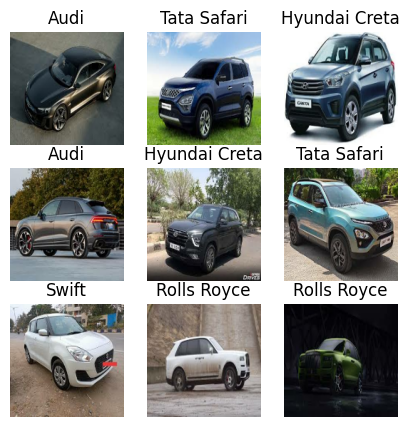

In [8]:
plt.figure(figsize=(5, 5))

for images, labels in train_dataset.take(1):
  for i in range(9):  # 9개의 이미지 출력
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))  # 이미지 표현을 위해 numpy 배열 dtype을 uint8로 지정
    plt.title(class_names[labels[i]])  # images에 해당하는 레이블 출력
    plt.axis("off") 

In [9]:
val_batches = tf.data.experimental.cardinality(validation_dataset)

test_dataset = validation_dataset.take(val_batches // 5)

validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

##### Data augmentation

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(0.3)
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


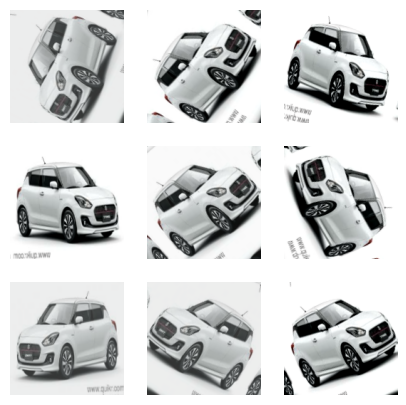

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(5,5))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    # tf.expand_dims를 통해 기존 이미지의 차원을 확장함 (first_image : 차원이 늘려질 배열, 0(axis) : 몇 번째 차원의 크기를 늘릴 것인지)
    # 차원 확장 후 이미지 증강 기법 적용
    # https://www.tensorflow.org/api_docs/python/tf/expand_dims
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Transfer learning - MobileNetV2

##### Feature Extraction

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# rescaling과 같은 기능

In [14]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [16]:
base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(7, activation='softmax')

In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)  # 데이터 증강
x = preprocess_input(x) # 전처리
x = base_model(x, training=False) # MobileNet V2d의 basemodel
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)  # output layer
model = tf.keras.Model(inputs, outputs)

##### Compile Model

In [18]:
base_learning_rate = 0.0001  # 학습률 지정
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [20]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
105/105 [==============================] - 12s 41ms/step - loss: 2.2226 - accuracy: 0.1915 - val_loss: 1.8000 - val_accuracy: 0.3231
Epoch 2/10
105/105 [==============================] - 3s 30ms/step - loss: 1.9877 - accuracy: 0.2652 - val_loss: 1.6083 - val_accuracy: 0.4456
Epoch 3/10
105/105 [==============================] - 3s 29ms/step - loss: 1.7872 - accuracy: 0.3344 - val_loss: 1.4699 - val_accuracy: 0.4992
Epoch 4/10
105/105 [==============================] - 3s 29ms/step - loss: 1.6554 - accuracy: 0.3816 - val_loss: 1.3968 - val_accuracy: 0.5253
Epoch 5/10
105/105 [==============================] - 3s 31ms/step - loss: 1.5356 - accuracy: 0.4338 - val_loss: 1.2867 - val_accuracy: 0.5574
Epoch 6/10
105/105 [==============================] - 3s 30ms/step - loss: 1.4801 - accuracy: 0.4558 - val_loss: 1.2296 - val_accuracy: 0.5911
Epoch 7/10
105/105 [==============================] - 3s 30ms/step - loss: 1.4142 - accuracy: 0.4860 - val_loss: 1.1635 - val_accuracy: 0.601

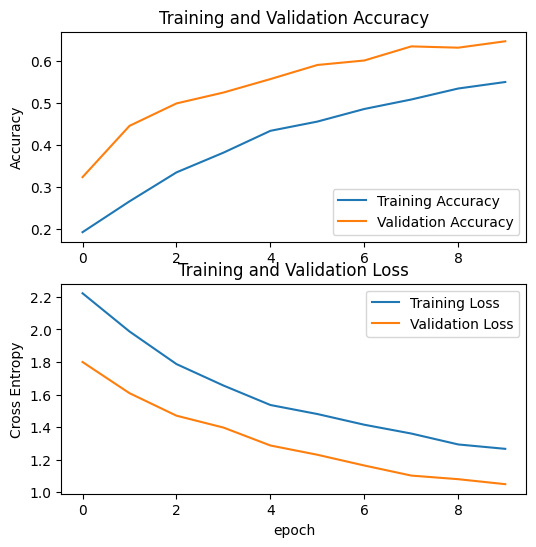

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Fine tuning

In [22]:
base_model.trainable = True

In [23]:
print(len(base_model.layers))

for i, j in enumerate(base_model.layers):
    print(i, j.name)

154
0 input_1
1 Conv1
2 bn_Conv1
3 Conv1_relu
4 expanded_conv_depthwise
5 expanded_conv_depthwise_BN
6 expanded_conv_depthwise_relu
7 expanded_conv_project
8 expanded_conv_project_BN
9 block_1_expand
10 block_1_expand_BN
11 block_1_expand_relu
12 block_1_pad
13 block_1_depthwise
14 block_1_depthwise_BN
15 block_1_depthwise_relu
16 block_1_project
17 block_1_project_BN
18 block_2_expand
19 block_2_expand_BN
20 block_2_expand_relu
21 block_2_depthwise
22 block_2_depthwise_BN
23 block_2_depthwise_relu
24 block_2_project
25 block_2_project_BN
26 block_2_add
27 block_3_expand
28 block_3_expand_BN
29 block_3_expand_relu
30 block_3_pad
31 block_3_depthwise
32 block_3_depthwise_BN
33 block_3_depthwise_relu
34 block_3_project
35 block_3_project_BN
36 block_4_expand
37 block_4_expand_BN
38 block_4_expand_relu
39 block_4_depthwise
40 block_4_depthwise_BN
41 block_4_depthwise_relu
42 block_4_project
43 block_4_project_BN
44 block_4_add
45 block_5_expand
46 block_5_expand_BN
47 block_5_expand_relu


In [24]:
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False
# block_11_expand_BN까지 학습을 동결함
# 블록 11의 맨 처음 Conv layer와 Batch Normal layer를 닫은 이후의 레이어들의 파라미터만 학습함

In [25]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [27]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


105/105 [==============================] - 9s 46ms/step - loss: 1.1337 - accuracy: 0.5964 - val_loss: 0.8568 - val_accuracy: 0.7274
Epoch 11/20
105/105 [==============================] - 4s 40ms/step - loss: 0.9983 - accuracy: 0.6590 - val_loss: 0.7245 - val_accuracy: 0.7626
Epoch 12/20
105/105 [==============================] - 4s 41ms/step - loss: 0.9086 - accuracy: 0.6838 - val_loss: 0.6519 - val_accuracy: 0.7810
Epoch 13/20
105/105 [==============================] - 5s 48ms/step - loss: 0.8201 - accuracy: 0.7133 - val_loss: 0.6177 - val_accuracy: 0.8009
Epoch 14/20
105/105 [==============================] - 5s 43ms/step - loss: 0.7623 - accuracy: 0.7375 - val_loss: 0.5369 - val_accuracy: 0.8285
Epoch 15/20
105/105 [==============================] - 4s 41ms/step - loss: 0.7129 - accuracy: 0.7485 - val_loss: 0.4867 - val_accuracy: 0.8331
Epoch 16/20
105/105 [==============================] - 4s 41ms/step - loss: 0.6510 - accuracy: 0.7780 - val_loss: 0.5064 - val_accuracy: 0.8239
Epoc

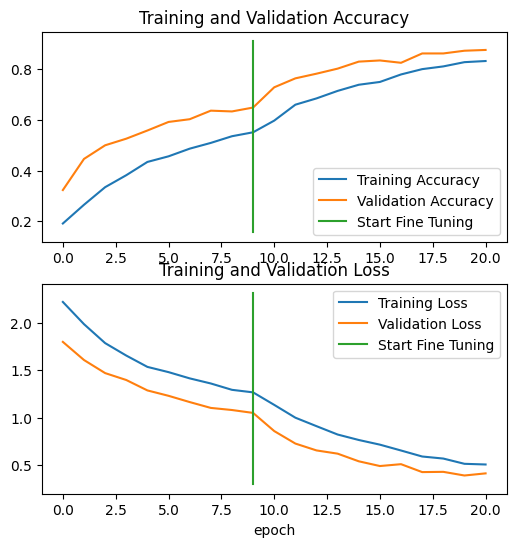

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Predict & Evaluation

In [29]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 0s 22ms/step - loss: 0.4080 - accuracy: 0.8813
Test accuracy : 0.8812500238418579


[0 6 6 6 0 6 5 0 1] [0 6 6 6 0 6 5 0 1]


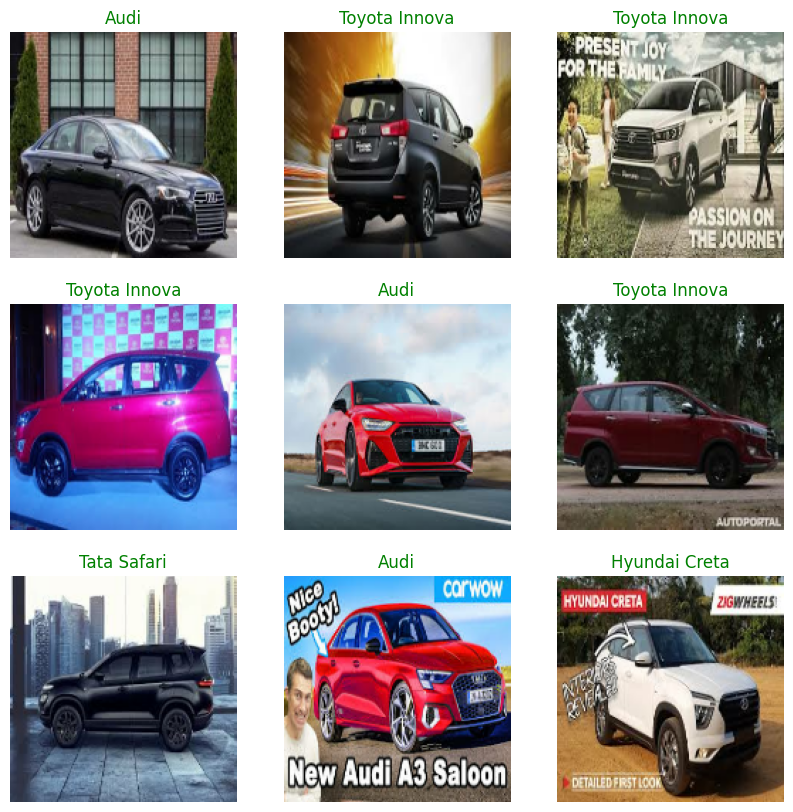

In [61]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
# print(predictions)
predBun=np.argmax(predictions, axis=-1)
# print(predBun)

print(predBun[:9], label_batch[:9])

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  color = "green" if predBun[i] == label_batch[i] else "red"
  # print(class_names[predBun[i]],label_batch[i], color)
  plt.title(class_names[predBun[i]], color=color)
  plt.axis("off")


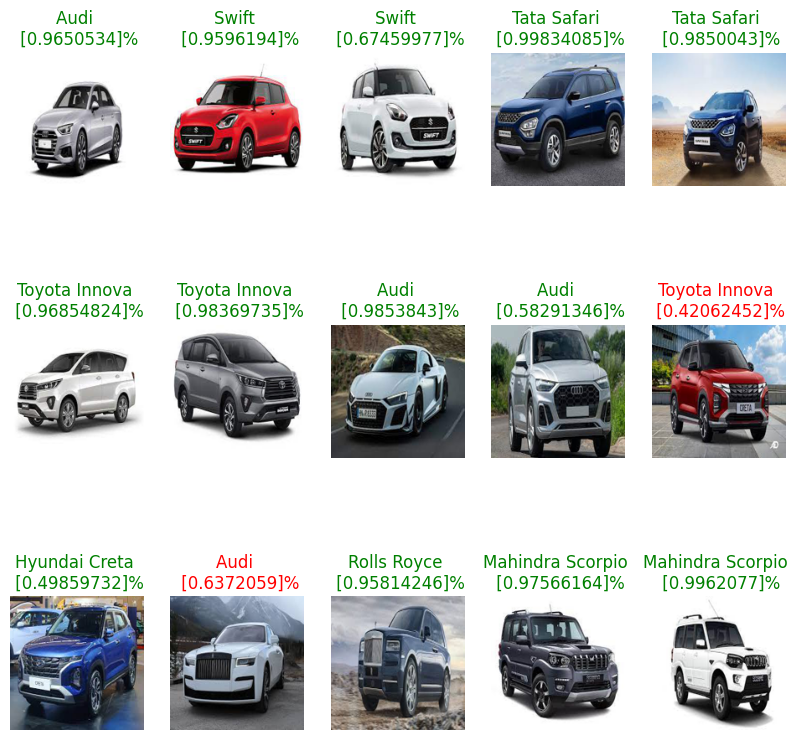

In [62]:
from PIL import Image
from glob import glob

test_dir = 'd:/CarsDataset/test_img/*'
test_files=glob(test_dir)

real_test_labes = [0,4,4,5,5,6,6,0,0,1,1,3,3,2,2]   # 실제 testset 라벨 값

plt.figure(figsize=(10,10))

for n, file in enumerate(test_files):
    ax=plt.subplot(3,5,n+1)
    img=Image.open(file).resize((160,160)).convert('RGB')
    img=np.array(img)
    newimg=np.reshape(img, (1,160,160,3))
    pred=model.predict(newimg)
    predBun=np.argmax(pred)
    # print(class_names[predBun], pred[:,predBun])
    plt.title(f'{class_names[predBun]}: {pred[:,predBun]}%')
    # plt.figure(figsize=(3,3))
    plt.imshow(img)
    color = "green" if predBun == real_test_labes[n] else "red"
    plt.title(f'{class_names[predBun]} \n {pred[:,predBun]}%', color=color)
    # plt.show()
    plt.axis("off")


In [63]:
import time
t = time.time()

export_path = "saved_models_MobileNetV2/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: saved_models_MobileNetV2/1688618774\assets


'saved_models_MobileNetV2/1688618774'

### Transfer learning - ResNet50

##### Feature Extraction

In [90]:
base_model_2 = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                                    include_top=False,
                                                    weights='imagenet')

In [91]:
base_model_2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']      

In [92]:
preprocess_input_2 = tf.keras.applications.resnet50.preprocess_input

In [93]:
base_model_2.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(7, activation='softmax')

In [94]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)  # 데이터 증강
x = preprocess_input_2(x) # 전처리
x = base_model_2(x, training=False) # MobileNet V2d의 basemodel
# x = tf.keras.layers.Dropout(0.2)(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)  # output layer
model_2 = tf.keras.Model(inputs, outputs)

In [95]:
model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem_4   (None, 160, 160, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_3   (None, 2048)             0   

##### Compile Model

In [96]:
base_learning_rate = 0.0001  # 학습률 지정
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [97]:
initial_epochs = 12

#러닝레이트의 비율을 유동적으로 변화할 수 있도록 설정함
def scheduler(epoch, learning_rate):
    if epoch < 5:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.1)
lr_scheduler_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

history_2 = model_2.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[lr_scheduler_cb])

Epoch 1/12


105/105 [==============================] - 10s 73ms/step - loss: 2.3234 - accuracy: 0.2294 - val_loss: 1.7594 - val_accuracy: 0.3798 - lr: 1.0000e-04
Epoch 2/12
105/105 [==============================] - 7s 67ms/step - loss: 1.9555 - accuracy: 0.3121 - val_loss: 1.5039 - val_accuracy: 0.4533 - lr: 1.0000e-04
Epoch 3/12
105/105 [==============================] - 7s 65ms/step - loss: 1.7213 - accuracy: 0.3866 - val_loss: 1.3569 - val_accuracy: 0.5268 - lr: 1.0000e-04
Epoch 4/12
105/105 [==============================] - 7s 65ms/step - loss: 1.6000 - accuracy: 0.4260 - val_loss: 1.2574 - val_accuracy: 0.5743 - lr: 1.0000e-04
Epoch 5/12
105/105 [==============================] - 7s 63ms/step - loss: 1.4893 - accuracy: 0.4737 - val_loss: 1.1612 - val_accuracy: 0.5896 - lr: 1.0000e-04
Epoch 6/12
105/105 [==============================] - 7s 63ms/step - loss: 1.3990 - accuracy: 0.5051 - val_loss: 1.0843 - val_accuracy: 0.6309 - lr: 9.0484e-05
Epoch 7/12
105/105 [==============================

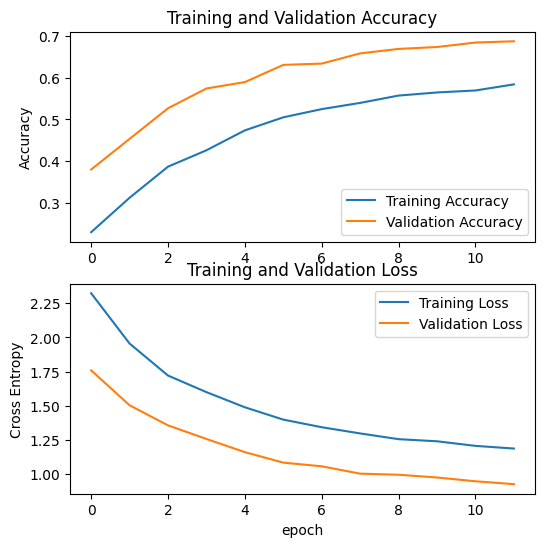

In [98]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Fine Tuning

In [99]:
base_model_2.trainable = True

print(len(base_model_2.layers))

for i, j in enumerate(base_model_2.layers):
    print(i, j.name)

175
0 input_9
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_

In [100]:
fine_tune_at = 100
#123
for layer in base_model_2.layers[:fine_tune_at]:
  layer.trainable = False

In [101]:
model_2.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [102]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine_2 = model_2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history_2.epoch[-1],
                         validation_data=validation_dataset)

Epoch 12/22
105/105 [==============================] - 16s 111ms/step - loss: 1.0385 - accuracy: 0.6337 - val_loss: 0.6365 - val_accuracy: 0.7795
Epoch 13/22
105/105 [==============================] - 11s 104ms/step - loss: 0.7965 - accuracy: 0.7261 - val_loss: 0.5272 - val_accuracy: 0.8070
Epoch 14/22
105/105 [==============================] - 11s 107ms/step - loss: 0.6295 - accuracy: 0.7804 - val_loss: 0.3943 - val_accuracy: 0.8606
Epoch 15/22
105/105 [==============================] - 11s 105ms/step - loss: 0.4976 - accuracy: 0.8291 - val_loss: 0.3738 - val_accuracy: 0.8606
Epoch 16/22
105/105 [==============================] - 11s 105ms/step - loss: 0.4559 - accuracy: 0.8428 - val_loss: 0.3282 - val_accuracy: 0.8836
Epoch 17/22
105/105 [==============================] - 11s 104ms/step - loss: 0.3689 - accuracy: 0.8732 - val_loss: 0.3152 - val_accuracy: 0.8775
Epoch 18/22
105/105 [==============================] - 11s 105ms/step - loss: 0.3338 - accuracy: 0.8899 - val_loss: 0.2383 -

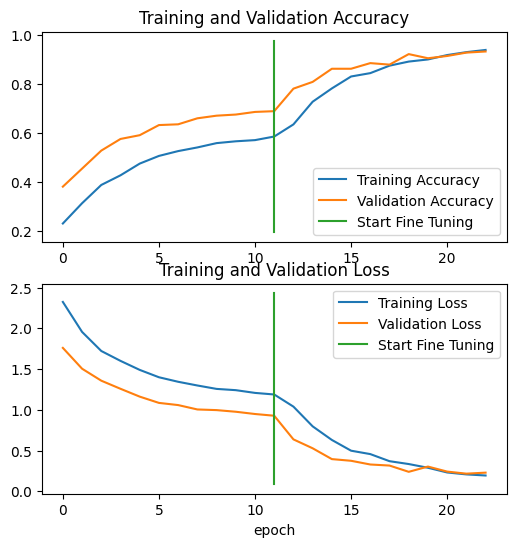

In [103]:
acc += history_fine_2.history['accuracy']
val_acc += history_fine_2.history['val_accuracy']

loss += history_fine_2.history['loss']
val_loss += history_fine_2.history['val_loss']

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Predict & Evaluation

In [104]:
loss, accuracy = model_2.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 1s 48ms/step - loss: 0.2411 - accuracy: 0.9187
Test accuracy : 0.918749988079071


[0 5 0 5 5 4 6 1 3] [0 5 0 5 5 4 6 1 3]


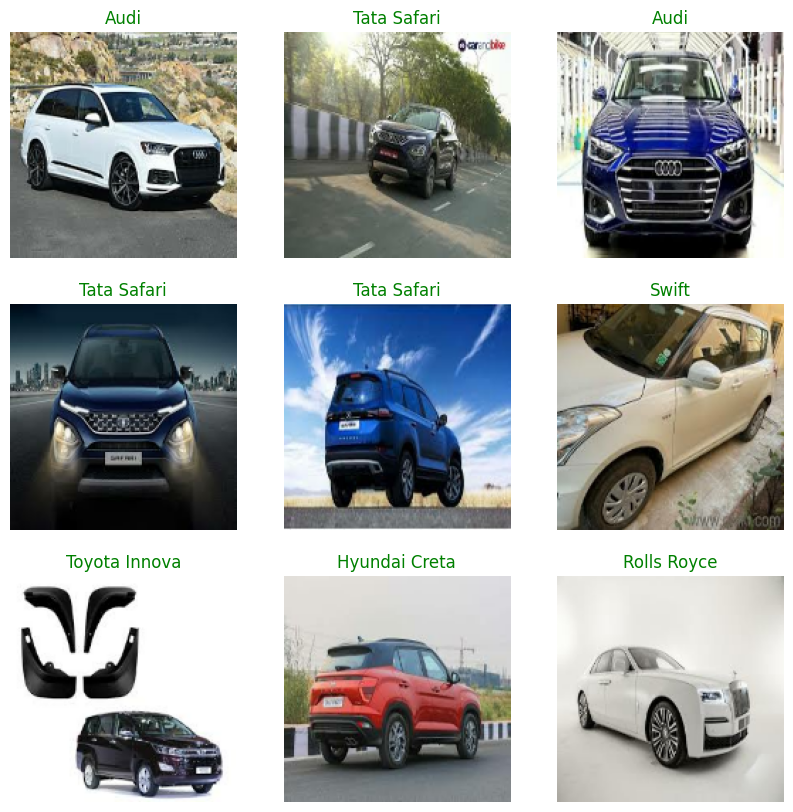

In [107]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model_2.predict_on_batch(image_batch)
# print(predictions)
predBun=np.argmax(predictions, axis=-1)
# print(predBun)

print(predBun[:9], label_batch[:9])

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  color = "green" if predBun[i] == label_batch[i] else "red"
  # print(class_names[predBun[i]],label_batch[i], color)
  plt.title(class_names[predBun[i]], color=color)
  plt.axis("off")


##### Test_image 적용

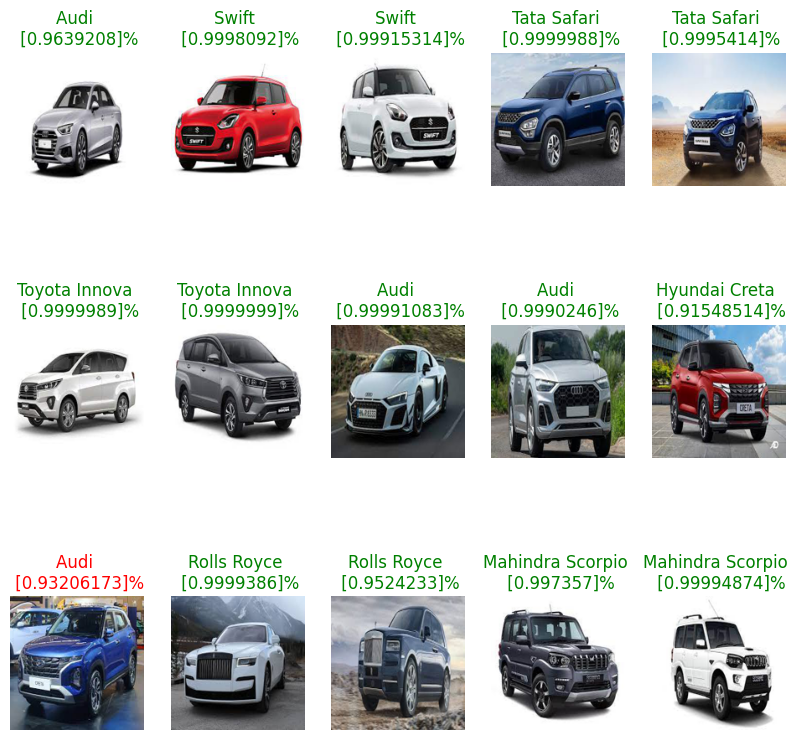

In [110]:
from PIL import Image
from glob import glob

test_dir = 'd:/CarsDataset/test_img/*'
test_files=glob(test_dir)

real_test_labes = [0,4,4,5,5,6,6,0,0,1,1,3,3,2,2]   # 실제 testset 라벨 값

plt.figure(figsize=(10,10))

for n, file in enumerate(test_files):
    ax=plt.subplot(3,5,n+1)
    img=Image.open(file).resize((160,160)).convert('RGB')
    img=np.array(img)
    newimg=np.reshape(img, (1,160,160,3))
    pred=model_2.predict(newimg)
    predBun=np.argmax(pred)
    # print(class_names[predBun], pred[:,predBun])
    plt.title(f'{class_names[predBun]}: {pred[:,predBun]}%')
    # plt.figure(figsize=(3,3))
    plt.imshow(img)
    color = "green" if predBun == real_test_labes[n] else "red"
    plt.title(f'{class_names[predBun]} \n {pred[:,predBun]}%', color=color)
    # plt.show()
    plt.axis("off")


In [111]:
export_path = "saved_models_ResNet50/{}".format(int(t))
model_2.save(export_path, save_format='tf')

export_path

INFO:tensorflow:Assets written to: saved_models_ResNet50/1688618774\assets


'saved_models_ResNet50/1688618774'

In [112]:
from keras.models import load_model

model_2.save('ResNet50_model.h5')